## Two-component Bose-Hubbard model

In [1]:
using QuantumOptics
using Plots
using Arpack
using ArnoldiMethod
using DelimitedFiles
using LaTeXStrings
using MATLAB
using LinearAlgebra
using Statistics
pyplot()

Plots.PyPlotBackend()

We'll use the many-body functionalities from QuantumOptics.jl to find the ground state of the two-component Bose-Hubbard model. Use the "levels" basis function to construct sites. The number of particles we specify is the number _per component_ so the total number of particles is 2`Nparticles`.

In [2]:
Nsites = 4
Nparticles = 4
a = NLevelBasis(Nsites)
a_mb = ManyBodyBasis(a, bosonstates(a, Nparticles))
b = NLevelBasis(Nsites)
b_mb = ManyBodyBasis(b, bosonstates(b, Nparticles))

ManyBody(onebodybasis=NLevel(N=4), states:35)

Potentially, we might want to clip the Hilbert space such that we can never have more than a certain number of particles per site. We'll assume that the particle number is limited on the component level. In the context of the experiment it means that the magnetization is preserved. The Hamiltonian is given by (with the creation/destruction operators $\hat{a}^{(\dagger)}$, $\hat{b}^{(\dagger)}$ acting on the single-component subspaces):

$$
    \mathcal{H} = -t \sum_{\langle i, j \rangle} \left( \hat{a}^\dagger_i \hat{a}_j + \hat{b}^\dagger_i \hat{b}_j \right) + \frac{U}{2} \sum_i \left[ \hat{n}_{a,i} \left( \hat{n}_{a,i} - 1 \right) + \hat{n}_{b,i} \left( \hat{n}_{b,i} - 1 \right) \right] + U_{AB} \sum_i \hat{n}_{a, i} \hat{n}_{b,i}.
$$

Here $U$ is the intraspecies interaction (which we assume to be the same for both components), and $U_{AB}$ is the interspecies interaction. For experiments in an isotropic lattice this differs by up to a few percent, but in a spin-dependent lattice we can tune it anywhere between $U$ and 0.

In [3]:
single_tunnel = [transition(b, i, i + 1) for i in 1 : (Nsites - 1)]
single_tunnel = [dagger.(single_tunnel) single_tunnel]
ta = sum([manybodyoperator(a_mb, t) for t in single_tunnel]);
tb = sum([manybodyoperator(b_mb, t) for t in single_tunnel]);

total_tunnel = (ta ⊗ identityoperator(b_mb)) + (identityoperator(a_mb) ⊗ tb)
intracomponent_interaction = sum([ identityoperator(a_mb) ⊗ ( number(b_mb, i) * (number(b_mb, i) - identityoperator(b_mb)) ) for i in 1:Nsites ])
intracomponent_interaction += sum([ ( number(a_mb, i ) * ( number(a_mb, i) - identityoperator(a_mb) ) ⊗ identityoperator(b_mb) ) for i in 1:Nsites ])
intercomponent_interaction = sum([ number(a_mb, i) ⊗ number(b_mb, i) for i in 1:Nsites ]);

In [4]:
H(t, U, UAB) = -t * total_tunnel + U/2 * intracomponent_interaction + UAB * intercomponent_interaction;

Or with the energy in units of $t$:

In [5]:
H(U, UAB) = -total_tunnel + U/2 * intracomponent_interaction + UAB * intercomponent_interaction;

We parametrize as follows:
$$
    a = U_{AB} / U \\
    b = U / t
$$

### Calculate phase diagram via gap size

Instead of using the `eigenenergies()` function from `QuantumOptics.jl` we get the raw matrix from the operator, and use ARPACK's `eigs()` function. For some parameters the default number of evaluations (300) is not large enough, and this will allow us to override that setting.

In [6]:
function gap(a, b)
    energies, ϕ = eigs(H(b, a*b).data, nev = 2, which = :SR, maxiter = 1000)
    real(energies[2] - energies[1])
end;

In [7]:
function gapWrite(a, b)
    gapdum = gap(a,b)
    io = open("gap_results.txt", "a")
    write(io, string(b, "\t", a, "\t", gapdum, "\n"))
    close(io)
    return gapdum
end;

In [8]:
gap(0.9977, 76.6)

0.2815472300972601

In [85]:
uRatios = [0:0.05:1.2;]
dimlessUs = [14.5:0.5:15;]

X = repeat(reshape(dimlessUs, 1, :), length(uRatios), 1)
Y = repeat(uRatios, 1, length(dimlessUs))
@time gapdata = map(gapWrite, Y, X);

4497.439412 seconds (886.87 k allocations: 13.528 GiB, 0.06% gc time)


Plotted using matplotlib in Python, since I cannot figure out how to change the color scale for instance in Julia:

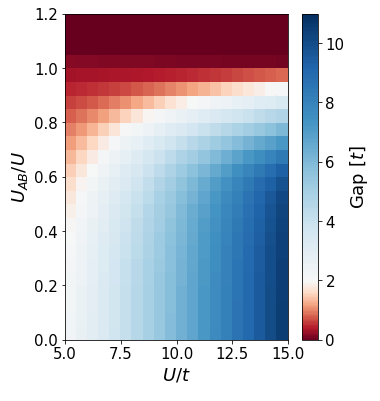

### Calculate spin-paired doublon fraction for fixed $U/t$

We need to define an operator that projects out the state with one $a$ and one $b$ boson on site $i$. This is what we call the spin-paired doublon fraction. We can average this over all sites to get the system-averaged number.

In [6]:
function spdfOp(i)
    numberOp = number(a_mb, i).data    # Start with the many-body number operator acting on site i
    projectHalfBasis = (real(numberOp) .== 1.0)    # Find states in the number operator that have a single particle on site i
    projectFullBasis = SparseOperator(a_mb, projectHalfBasis) ⊗ SparseOperator(b_mb, projectHalfBasis)    # Construct operator that filters out with one "a" and one "b" particle on site i
end

spdfOp (generic function with 1 method)

To show how this works, we can define a state with clearly defined spin pairs. We see there are two sites with one particle of each species. These are spin-paired doublons.

We calculate the spin-paired doublon fraction by summing the expectation value of `spdfOp` over all sites, and taking the average:

Now for real. We get the ground state and evaluate the same expression:

In [7]:
function getSPDF(a, b)
    energies, ϕ = eigs(H(b, a*b).data, nev = 2, which = :SR, maxiter = 1000)
    gs = Ket(a_mb ⊗ b_mb, ϕ[:, 1]);
    real(sum([expect(spdfOp(i), gs) for i in 1:Nsites])/Nsites)
end

function getSPDF2(a, b)
    # Use the partial Schur decomposition supplied by ArnoldiMethod, this is faster
    decomp, history = partialschur(H(b, a*b).data, nev=2, tol=1e-6, which=SR());
    λ, ϕ = partialeigen(decomp)
    gs = Ket(a_mb ⊗ b_mb, ϕ[:, 1])
    real(sum([expect(spdfOp(i), gs) for i in 1:Nsites])/Nsites)
end

getSPDF2 (generic function with 1 method)

In [18]:
as = [0:0.05:1;]
spdfs = [getSPDF2(a, 10) for a in as];

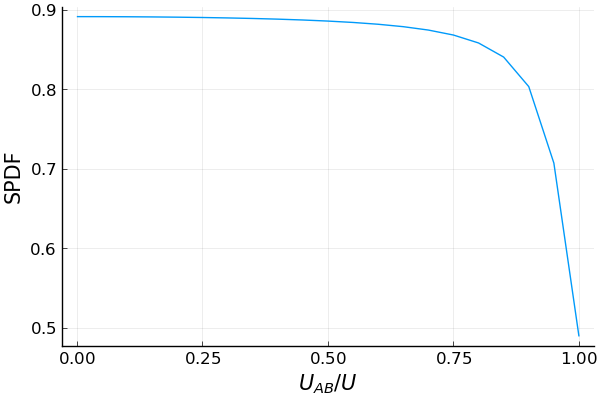

In [19]:
plot(as, spdfs,
    xlabel = L"U_{AB}/U",
    ylabel = "SPDF",
    xguidefont = font(15),
    yguidefont = font(15),
    tickfont = font(12),
    leg = false)